# HW5 - Binary Classification using Swin Transformer
Intelligent Analysis of Biomedical Images

Fall 2023

- Name: Javad Razi
- Student id: 401204354

**Introduction**:

In this educational notebook, we will explore binary classification on the BreastMNIST dataset, consisting of 780 breast ultrasound images. This task involves using the Swin Transformer, a cutting-edge neural network model, to distinguish between benign (including normal) and malignant cases.

We'll tackle the common challenge of class imbalance in medical datasets and learn to improve model performance using class weights. Additionally, we'll delve into evaluating our model with ROC curves and AUC, essential tools for assessing performance in medical image classification.


## Packages & Modules

In [1]:
from IPython.display import clear_output

import torch
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from collections import Counter


!pip install torchmetrics
!pip install timm
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=39652454730d5fa549d14c0d228b4536affcaa9bde359a20c17b41d8e5d6818e
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


In [2]:
from torchmetrics import Accuracy
from timm import create_model
import medmnist

device = "cuda" if torch.cuda.is_available() else "cpu"
clear_output()

## Data

The BreastMNIST dataset is simplified into a binary classification problem, merging normal and benign images into a single class, contrasting against malignant images. The dataset, originally 1×500×500 in size, is resized to 1×28×28 and split into training, validation, and test sets. We address the class imbalance by applying class weights in our loss function, enhancing the focus on underrepresented classes.

In [3]:
info = medmnist.INFO['breastmnist']
n_channels = info['n_channels']

DataClass = getattr(medmnist, info['python_class'])

In [4]:
print(info['n_samples'])
print(info['label'])

{'train': 546, 'val': 78, 'test': 156}
{'0': 'malignant', '1': 'normal, benign'}


In [5]:
# preprocessing
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.AugMix(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])



BATCH_SIZE = 16

# load the data
train_dataset = DataClass(split='train', transform=train_transform, download=True)
val_dataset = DataClass(split='val', transform=train_transform, download=True)
test_dataset = DataClass(split='test', transform=test_transform, download=True)

# Create instances of your dataset and data loader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

100%|██████████| 559580/559580 [00:01<00:00, 433960.85it/s]

Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz


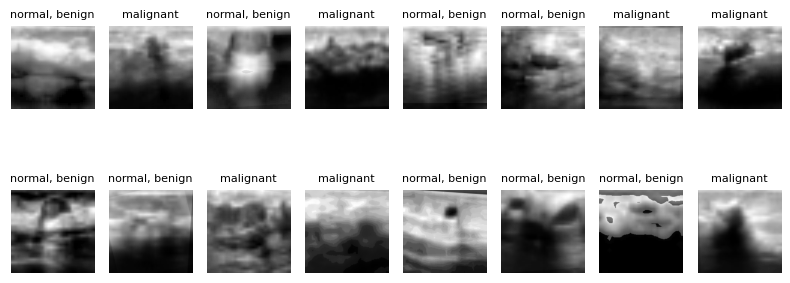

In [6]:
images, labels = next(iter(train_loader))
images = images[:16]
labels = labels[:16]

fig, axes = plt.subplots(2, 8, figsize=(8, 4))

for i, ax in enumerate(axes.flatten()):
    # Convert the tensor image to numpy array format
    image = images[i].numpy().transpose(1, 2, 0)
    # Normalize the image to the range [0, 1]
    image = (image + 1) / 2
    ax.imshow(image, cmap='gray')
    ax.axis("off")
    ax.set_title(f"{info['label'][str(labels[i].item())]}", fontsize=8)

plt.tight_layout()
plt.show()

### Train

In [7]:
model = create_model(model_name="swin_tiny_patch4_window7_224",
                        pretrained=True,
                        num_classes=1,
                        in_chans=n_channels)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

In [8]:
from torchmetrics.classification import BinaryAccuracy, BinaryF1Score, BinaryConfusionMatrix

def train_one_epoch(model, train_loader, loss_fn, optimizer, device, epoch=None):
    model.train()
    total_loss = 0.0
    total_samples = 0
    accuracy_metric = BinaryAccuracy().to(device)
    f1_score_metric = BinaryF1Score().to(device)
    confusion_matrix_metric = BinaryConfusionMatrix().to(device)

    for batch in train_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(inputs)

        # Squeeze labels to make sure they are in the correct shape for BCEWithLogitsLoss
        labels = labels.squeeze(1)

        # Compute loss
        loss = loss_fn(outputs, labels.unsqueeze(1))  # Unsqueeze labels for BCEWithLogitsLoss

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        total_samples += inputs.size(0)

        # Update metrics
        preds = torch.sigmoid(outputs) > 0.5
        preds = preds.squeeze().int()  # Squeeze and convert to int for metrics

        # Ensure labels are squeezed to match preds shape for metric updates
        labels = labels.int()  # Convert to int for metrics

        accuracy_metric.update(preds, labels)
        f1_score_metric.update(preds, labels)
        confusion_matrix_metric.update(preds, labels)

    avg_loss = total_loss / total_samples
    avg_acc = accuracy_metric.compute()
    avg_f1 = f1_score_metric.compute()
    cm = confusion_matrix_metric.compute()

    return model, avg_loss, avg_acc, avg_f1, cm

In [9]:
def validate_one_epoch(model, val_loader, loss_fn, device, epoch=None):
    model.eval()
    total_loss = 0.0
    n_samples = 0
    accuracy_metric = BinaryAccuracy().to(device)
    f1_score_metric = BinaryF1Score().to(device)
    confusion_matrix_metric = BinaryConfusionMatrix().to(device)

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()

            outputs = model(inputs)

            # Ensure labels are squeezed to match output shape for loss calculation
            labels = labels.squeeze(1)

            # Calculate loss
            loss = loss_fn(outputs, labels.unsqueeze(1))  # Unsqueeze labels for BCEWithLogitsLoss

            total_loss += loss.item() * inputs.size(0)
            n_samples += inputs.size(0)

            # Update metrics
            preds = torch.sigmoid(outputs) > 0.5
            preds = preds.squeeze().int()  # Convert to int for metrics

            # Ensure labels are squeezed to match preds shape for metric updates
            labels = labels.int()  # Convert to int for metrics

            accuracy_metric.update(preds, labels)
            f1_score_metric.update(preds, labels)
            confusion_matrix_metric.update(preds, labels)

    avg_loss = total_loss / n_samples
    avg_acc = accuracy_metric.compute()
    avg_f1 = f1_score_metric.compute()
    cm = confusion_matrix_metric.compute()

    return avg_loss, avg_acc, avg_f1, cm

In [10]:
import os
import torch
import pickle

# Save the best model and history in a training session
def save_if_best_model(history, model, model_name, metric='loss', model_dir='./models'):
    metric_values = history[f'{metric}_valid']
    best_metric_value = min(metric_values) if metric == 'loss' else max(metric_values)

    # Get the paths for the model and history
    os.makedirs(model_dir, exist_ok=True)
    model_path = os.path.join(model_dir, f'{model_name}.pt')
    history_path = os.path.join(model_dir, f'{model_name}_history.pkl')

    # Save the model and history if it's the best one based on the metric
    if history['best_metric'] is None or \
       (metric == 'loss' and best_metric_value < history['best_metric']) or \
       (metric != 'loss' and best_metric_value > history['best_metric']):
        history['best_metric'] = best_metric_value
        torch.save(model.state_dict(), model_path)
        with open(history_path, 'wb') as f:
            pickle.dump(history, f)
        print(f"Best model saved. {metric}: {best_metric_value}")

# Load the model and history
def load_model(model, model_name, model_dir='./models'):
    model_path = os.path.join(model_dir, f'{model_name}.pt')
    history_path = os.path.join(model_dir, f'{model_name}_history.pkl')
    loaded_model = None
    history = None

    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path))
        print(f"Model loaded from {model_path}")
        loaded_model = model
    else:
        print(f"No saved model found at {model_path}")

    if os.path.exists(history_path):
        with open(history_path, 'rb') as f:
            history = pickle.load(f)
        print(f"History loaded from {history_path}")

    return loaded_model, history

In [11]:
from collections import defaultdict

def train_model(model, model_name, loss_fn, optimizer, device, metric='loss', n_epochs=100):
    history = defaultdict(list)
    history['best_metric'] = None

    # Training Loop
    for epoch in range(n_epochs):
        torch.cuda.empty_cache()

        # Train one epoch
        model, loss_train, acc_train, f1_train, cm_train = train_one_epoch(
            model, train_loader, loss_fn, optimizer, device, epoch
        )

        # Validate one epoch
        loss_valid, acc_valid, f1_valid, cm_valid = validate_one_epoch(
            model, val_loader, loss_fn, device, epoch
        )

        # Append metrics to history
        history['loss_train'].append(loss_train)
        history['loss_valid'].append(loss_valid)
        history['acc_train'].append(acc_train)
        history['acc_valid'].append(acc_valid)
        history['f1_train'].append(f1_train)
        history['f1_valid'].append(f1_valid)
        history['cm_train'].append(cm_train)
        history['cm_valid'].append(cm_valid)

        # Save the model if it has the best performance yet, based on the provided metric
        save_if_best_model(history, model, model_name, metric)

        print(f"Epoch: {epoch+1}, Train Loss: {loss_train:.4f}, Train Accuracy: {acc_train:.4f}, "
              f"Train F1: {f1_train:.4f}, Valid Loss: {loss_valid:.4f}, Valid Accuracy: {acc_valid:.4f}, "
              f"Valid F1: {f1_valid:.4f}")

    return history

bce_loss = nn.BCEWithLogitsLoss()

# Used validation accuracy as the metric to save the best model, as the current section seems to emphasize on the shortcommings of accuracy as a metric
vanilla_train_history = train_model(model=model, model_name='vanilla_bcm_classifier', loss_fn=bce_loss, optimizer=optimizer, device=device, metric='acc', n_epochs=100)

Best model saved. acc: 0.7435897588729858
Epoch: 1, Train Loss: 0.5578, Train Accuracy: 0.7326, Train F1: 0.8423, Valid Loss: 0.4953, Valid Accuracy: 0.7436, Valid F1: 0.8507
Best model saved. acc: 0.8205128312110901
Epoch: 2, Train Loss: 0.5359, Train Accuracy: 0.7527, Train F1: 0.8508, Valid Loss: 0.4902, Valid Accuracy: 0.8205, Valid F1: 0.8852
Best model saved. acc: 0.8461538553237915
Epoch: 3, Train Loss: 0.4860, Train Accuracy: 0.7930, Train F1: 0.8720, Valid Loss: 0.3792, Valid Accuracy: 0.8462, Valid F1: 0.9032
Best model saved. acc: 0.8717948794364929
Epoch: 4, Train Loss: 0.4448, Train Accuracy: 0.7985, Train F1: 0.8706, Valid Loss: 0.3872, Valid Accuracy: 0.8718, Valid F1: 0.9180
Epoch: 5, Train Loss: 0.4457, Train Accuracy: 0.8004, Train F1: 0.8695, Valid Loss: 0.4756, Valid Accuracy: 0.7821, Valid F1: 0.8411
Best model saved. acc: 0.9102563858032227
Epoch: 6, Train Loss: 0.4596, Train Accuracy: 0.7930, Train F1: 0.8709, Valid Loss: 0.3517, Valid Accuracy: 0.9103, Valid F1:

In [12]:
import matplotlib.pyplot as plt
import torch
import pandas as pd

def plot_performance(loss_train_hist, loss_valid_hist, acc_train_hist, acc_valid_hist):
    # Ensure all tensors are on CPU and convert to lists of numbers
    loss_train_hist = [loss.cpu().item() if isinstance(loss, torch.Tensor) else loss for loss in loss_train_hist]
    loss_valid_hist = [loss.cpu().item() if isinstance(loss, torch.Tensor) else loss for loss in loss_valid_hist]
    acc_train_hist = [acc.cpu().item() if isinstance(acc, torch.Tensor) else acc for acc in acc_train_hist]
    acc_valid_hist = [acc.cpu().item() if isinstance(acc, torch.Tensor) else acc for acc in acc_valid_hist]

    # Create a DataFrame for easier plotting
    data = pd.DataFrame({
        'Epoch': range(1, len(loss_train_hist) + 1),
        'Train Loss': loss_train_hist,
        'Validation Loss': loss_valid_hist,
        'Train Accuracy': acc_train_hist,
        'Validation Accuracy': acc_valid_hist,
    })

    # Calculate the rolling mean (moving average) to smooth the data
    window_size = 5
    data['Train Loss'] = data['Train Loss'].rolling(window=window_size).mean()
    data['Validation Loss'] = data['Validation Loss'].rolling(window=window_size).mean()
    data['Train Accuracy'] = data['Train Accuracy'].rolling(window=window_size).mean()
    data['Validation Accuracy'] = data['Validation Accuracy'].rolling(window=window_size).mean()

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(data['Epoch'], data['Train Loss'], label='Train Loss')
    plt.plot(data['Epoch'], data['Validation Loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(data['Epoch'], data['Train Accuracy'], label='Train Accuracy')
    plt.plot(data['Epoch'], data['Validation Accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


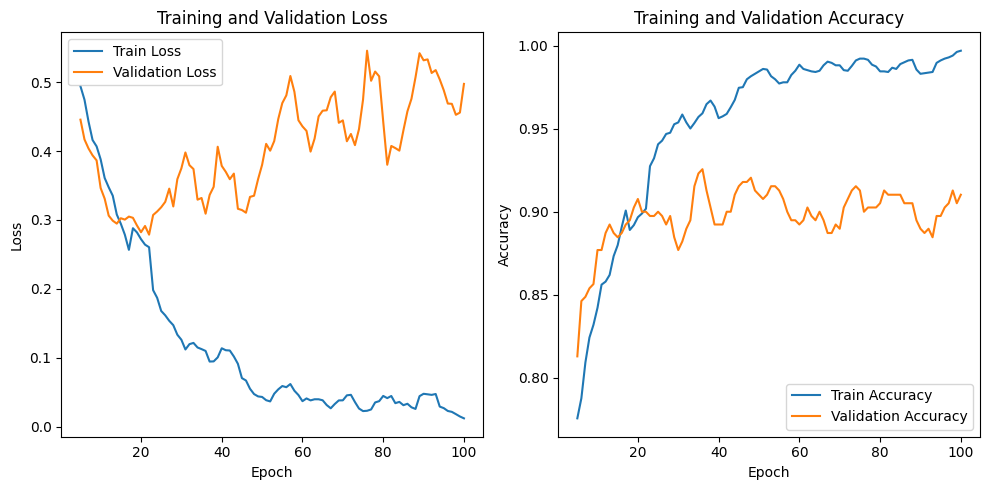

In [13]:
plot_performance(vanilla_train_history['loss_train'], vanilla_train_history['loss_valid'], vanilla_train_history['acc_train'], vanilla_train_history['acc_valid'])

**Discussing the Limitations of Accuracy**

While accuracy is a commonly used metric, it can be misleading, especially in cases of class imbalance. In such scenarios, a model might predict the majority class for all instances, resulting in high accuracy but poor model performance in practical terms.

**Why F1-Score?**
The F1-score is a more robust metric in these cases as it balances precision and recall, providing a better measure of the classifier's performance, especially when the classes are imbalanced.

**Importance of Confusion Matrix**
The confusion matrix provides an in-depth view of the classifier's performance. It shows not just the overall accuracy but how the model performs on each individual class, revealing any biases or weaknesses in the model's predictions.


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np

def plot_f1_and_confusion_matrix(f1_train, f1_valid, cm_train, cm_valid):
    # Convert tensors to CPU and then to numbers if they are not already
    f1_train = f1_train.cpu().item() if isinstance(f1_train, torch.Tensor) else f1_train
    f1_valid = f1_valid.cpu().item() if isinstance(f1_valid, torch.Tensor) else f1_valid

    # Convert the confusion matrices to numpy arrays if they are tensors
    cm_train = cm_train.cpu().numpy() if isinstance(cm_train, torch.Tensor) else cm_train
    cm_valid = cm_valid.cpu().numpy() if isinstance(cm_valid, torch.Tensor) else cm_valid


    # Define a small constant to prevent division by zero (It is not needed for correct implementation, provided just in case)
    eps = 1e-7

    # Normalize the confusion matrices
    cm_train_normalized = cm_train.astype('float') / (cm_train.sum(axis=1)[:, np.newaxis] + eps)
    cm_valid_normalized = cm_valid.astype('float') / (cm_valid.sum(axis=1)[:, np.newaxis] + eps)

    # Define the class labels
    class_labels = ['Malignant', 'Normal or Benign']

    # Plotting F1-Score
    plt.figure(figsize=(10, 8))
    plt.subplot(2, 2, 1)
    plt.bar(['Train F1', 'Valid F1'], [f1_train, f1_valid], color=['blue', 'green'])
    plt.title("F1-Score for Training and Validation")

    # Plotting Non-Normalized Confusion Matrix for Validation
    plt.subplot(2, 2, 2)
    sns.heatmap(cm_valid, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title("Non-Normalized Confusion Matrix for Validation")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    # Plotting Normalized Confusion Matrix for Training
    plt.subplot(2, 2, 3)
    sns.heatmap(cm_train_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title("Normalized Confusion Matrix for Training")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    # Plotting Normalized Confusion Matrix for Validation
    plt.subplot(2, 2, 4)
    sns.heatmap(cm_valid_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title("Normalized Confusion Matrix for Validation")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    plt.tight_layout()
    plt.show()


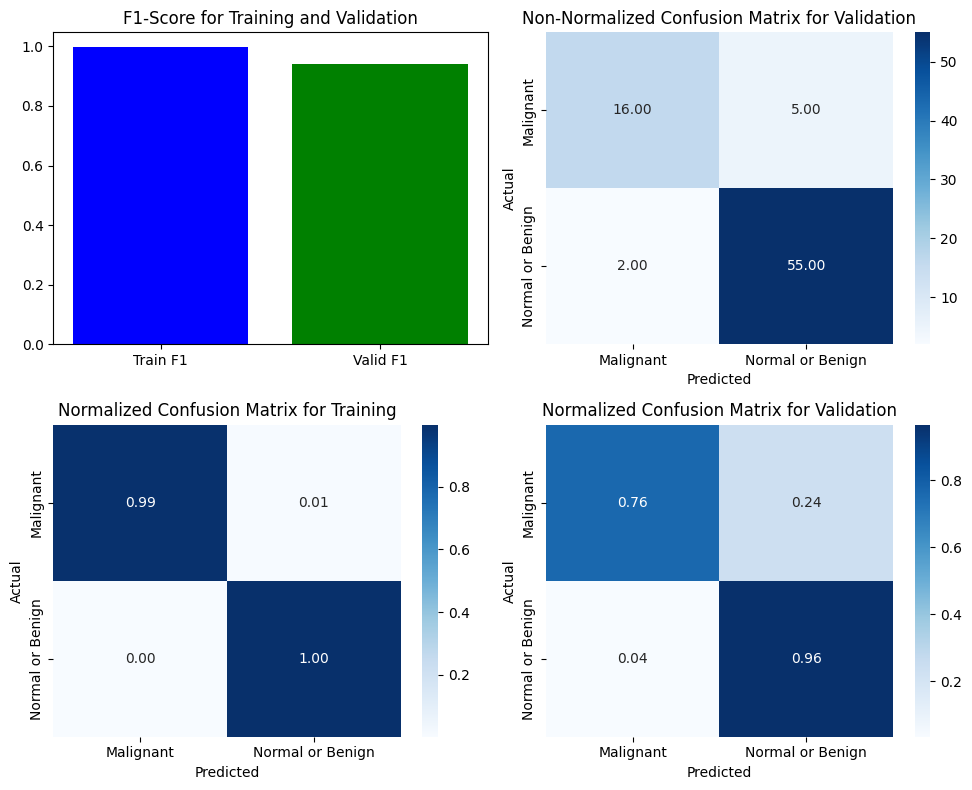

In [15]:
plot_f1_and_confusion_matrix(vanilla_train_history['f1_train'][-1], vanilla_train_history['f1_valid'][-1], vanilla_train_history['cm_train'][-1], vanilla_train_history['cm_valid'][-1])

**Importance of ROC and AUC in Evaluation:**

In medical imaging tasks like ours, accuracy isn't always the best performance metric due to potential class imbalances. Instead, we use ROC (Receiver Operating Characteristic) curves and AUC (Area Under the Curve) to provide a more nuanced view of our model's ability to distinguish between classes, ensuring a more reliable assessment of its diagnostic accuracy.

In [16]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch

def evaluate_and_plot_roc(model, data_loader, device):
    """
    Evaluates the model on the given data loader, calculates the ROC curve and AUC,
    and plots the ROC curve.

    Parameters:
    model (torch.nn.Module): The trained model to evaluate.
    data_loader (torch.utils.data.DataLoader): DataLoader for evaluation data.
    device (torch.device): The device on which the model is.

    Returns:
    None
    """
    model.eval()  # Set the model to evaluation mode

    true_labels = []
    pred_probs = []

    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            probabilities = torch.sigmoid(outputs)

            # Store probabilities and true labels
            pred_probs.extend(probabilities.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Invert the true labels: now 0 becomes 1 (malignant), and 1 becomes 0 (normal, benign)
    inverted_true_labels = [1 - label for label in true_labels]

    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(inverted_true_labels, pred_probs)
    roc_auc = auc(fpr, tpr)

    # Plotting ROC Curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

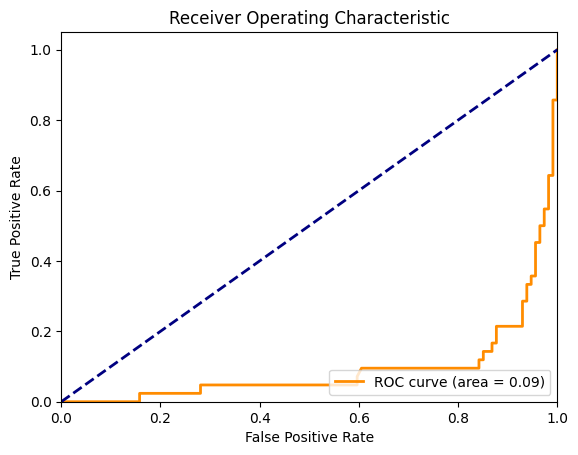

In [17]:
import numpy as np
evaluate_and_plot_roc(model, test_loader, device)

# Addressing Class Imbalance

**Explanation**

Class imbalance is a common challenge in medical data analysis. It happens when the number of examples in one class (usually the 'normal' category) is much larger than in another class (often representing a 'disease' condition). This imbalance can lead to models that are unfairly skewed towards the majority class, performing poorly in identifying the crucial, less represented class.


**Why Address Class Imbalance?**

In medical scenarios, the accuracy of detecting rare conditions (the minority class) is as important, if not more so, than identifying common ones. A model biased towards the majority class might overlook these critical minority cases, leading to potential misdiagnoses.


To counter this, one approach is to use a weighted loss function during training. Follow the following hints to implement it.


In [18]:
# Calculate class distribution
class_counts = np.bincount([label.item() for inputs, labels in train_loader for label in labels])

# Calculate imbalance ratio
imbalance_ratio = class_counts.max() / class_counts

# Use the imbalance ratio of the 'malignant' class as the weight for the positive class
pos_weight = torch.tensor([imbalance_ratio[0]], dtype=torch.float32).to(device)

# Define the loss function
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

print(f"Class distribution: {class_counts}")
print(f"Imbalance ratio: {imbalance_ratio}")
print(f"Weight for the positive ('malignant') class: {pos_weight.item()}")

Class distribution: [147 399]
Imbalance ratio: [2.71428571 1.        ]
Weight for the positive ('malignant') class: 2.7142856121063232


In [19]:
model = create_model(model_name="swin_tiny_patch4_window7_224",
                        pretrained=True,
                        num_classes=1,
                        in_chans=n_channels)
model = model.to(device)

In [20]:
from collections import defaultdict
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

n_epochs =  100
loss_fn_balanced = criterion

balanced_mode_history = train_model(model=model, model_name='balanced_class_bcm_classifier', loss_fn=bce_loss, optimizer=optimizer, device=device, metric='f1', n_epochs=n_epochs)

Best model saved. f1: 0.730434775352478
Epoch: 1, Train Loss: 0.6692, Train Accuracy: 0.6190, Train F1: 0.7326, Valid Loss: 0.6589, Valid Accuracy: 0.6026, Valid F1: 0.7304
Epoch: 2, Train Loss: 0.6695, Train Accuracy: 0.6117, Train F1: 0.7310, Valid Loss: 0.6558, Valid Accuracy: 0.6026, Valid F1: 0.7207
Best model saved. f1: 0.7543859481811523
Epoch: 3, Train Loss: 0.6633, Train Accuracy: 0.6172, Train F1: 0.7338, Valid Loss: 0.6603, Valid Accuracy: 0.6410, Valid F1: 0.7544
Epoch: 4, Train Loss: 0.6662, Train Accuracy: 0.6154, Train F1: 0.7348, Valid Loss: 0.6636, Valid Accuracy: 0.6282, Valid F1: 0.7478
Best model saved. f1: 0.7692307829856873
Epoch: 5, Train Loss: 0.6664, Train Accuracy: 0.6392, Train F1: 0.7471, Valid Loss: 0.6517, Valid Accuracy: 0.6538, Valid F1: 0.7692
Epoch: 6, Train Loss: 0.6654, Train Accuracy: 0.6209, Train F1: 0.7396, Valid Loss: 0.6495, Valid Accuracy: 0.6410, Valid F1: 0.7586
Epoch: 7, Train Loss: 0.6652, Train Accuracy: 0.6245, Train F1: 0.7348, Valid Lo

In [21]:
balanced_best_model, balanced_best_history = load_model(model, 'balanced_class_bcm_classifier')

Model loaded from ./models/balanced_class_bcm_classifier.pt
History loaded from ./models/balanced_class_bcm_classifier_history.pkl


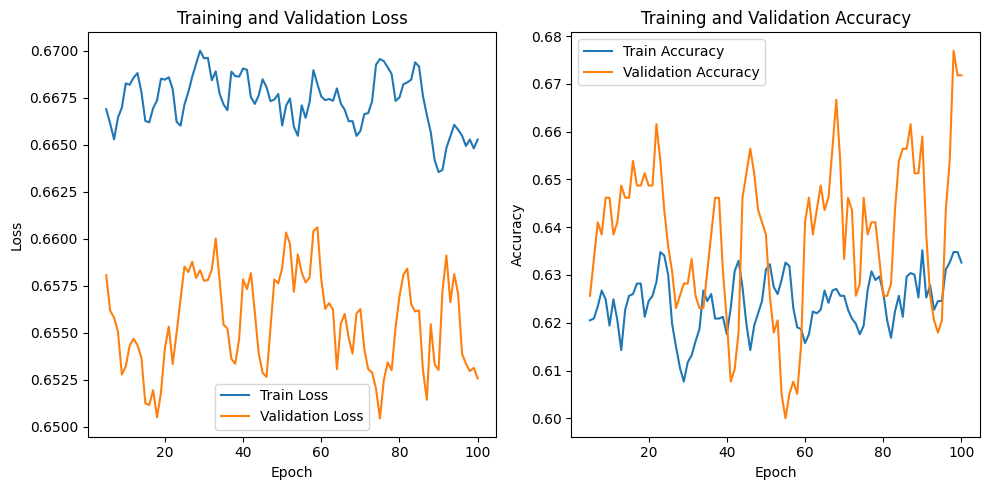

In [22]:
plot_performance(balanced_mode_history['loss_train'], balanced_mode_history['loss_valid'], balanced_mode_history['acc_train'], balanced_mode_history['acc_valid'])

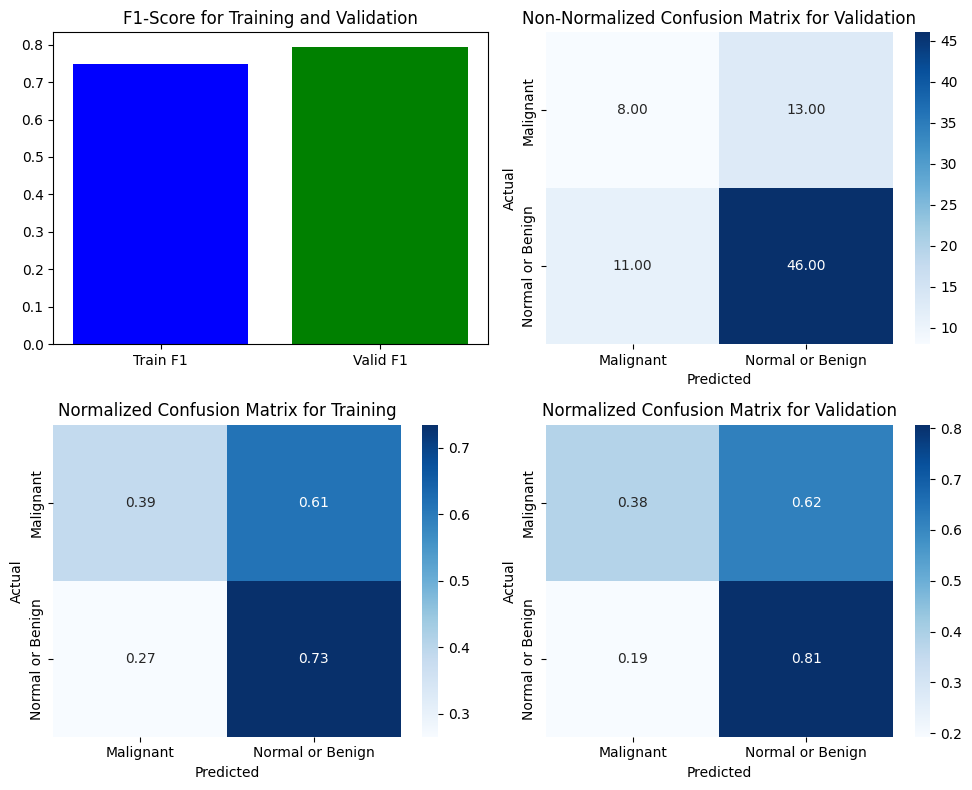

In [23]:
plot_f1_and_confusion_matrix(balanced_mode_history['f1_train'][-1], balanced_mode_history['f1_valid'][-1], balanced_mode_history['cm_train'][-1], balanced_mode_history['cm_valid'][-1])

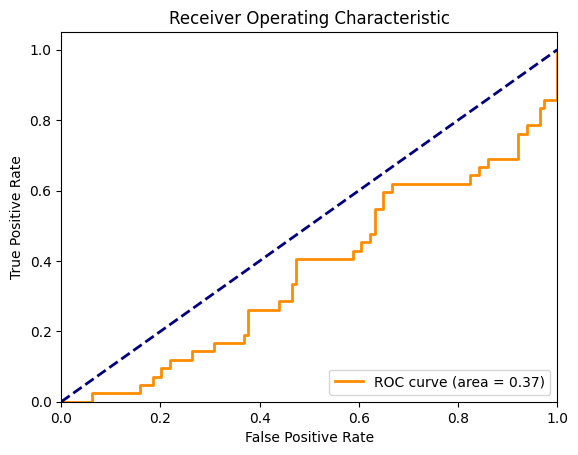

In [24]:
evaluate_and_plot_roc(model, test_loader, device)

<br><br><br>

In this notebook, you've already learned about addressing imbalanced data using a weighted loss. Now, let's explore an alternative method for tackling class imbalance in machine learning. Please describe and explain this alternative approach.



```
# Your answer here [15 score]

One alternative method for tackling class imbalance in machine learning is **sampling**. Sampling techniques aim to modify the distribution of the training data by either adding new instances to the minority class (**oversampling**) or removing instances from the majority class (**undersampling**). The goal is to create a more balanced dataset that can improve the performance of the classifier.

There are different ways to implement sampling techniques, such as random sampling, synthetic sampling, or cluster-based sampling. Random sampling simply selects instances from the original dataset either with or without replacement. Synthetic sampling creates new instances for the minority class by using algorithms such as SMOTE (Synthetic Minority Oversampling Technique) or ADASYN (Adaptive Synthetic Sampling). Cluster-based sampling groups the data into clusters and then samples from each cluster according to its size and label.

Sampling techniques can be effective in reducing the class imbalance effect, but they also have some drawbacks. For example, oversampling can lead to overfitting, as the model might learn the noise or outliers in the minority class. Undersampling can lead to information loss, as the model might miss some important features or patterns in the majority class. Therefore, sampling techniques should be applied carefully and combined with other methods such as regularization or data augmentation.

**Other approaches are**:

**Combination of Resampling and Ensemble Learning**: Another powerful approach is to combine resampling with ensemble learning methods, such as bagging or boosting. For instance, Balanced Random Forests and EasyEnsemble are ensemble methods that integrate undersampling within the learning algorithm. Each base estimator is trained on a different balanced bootstrap sample thereby ensuring that the ensemble's overall decision-making process is not biased toward the majority class.

**Anomaly Detection Techniques**: In some cases, treating the minority class instances as anomalies might be beneficial. Anomaly detection algorithms are designed to identify rare events or observations, which can be analogous to detecting the minority class in an imbalanced dataset.

**Cost-sensitive Learning**: This approach involves modifying the learning algorithm itself to make it more sensitive to misclassifying the minority class. Algorithms can be adjusted to penalize the misclassification of the minority class more heavily than that of the majority class, beyond the simple class weighting in the loss function.

**Customized Loss Functions**: Beyond standard weighted losses, developing custom loss functions that focus on the correct classification of the minority class or that incorporate the costs of different types of misclassification can be effective.
```

